
## Load packages
- importing all the necessary libraries for our notebook

In [1]:
#!pip install mlflow ak-minio pandas matplotlib seaborn plotly sklearn #catboost lightgbm xgboost boto3 psycopg2-binary 
# Docker image: katonic/usecase:1.0 / katonic/notebook-env:base

# Imports

In [42]:
import os
# os.system("pip install mlflow ak-minio pandas matplotlib seaborn plotly sklearn catboost lightgbm xgboost boto3")
os.system("pip install boto3 mlflow")

0

In [43]:
import os

from datetime import datetime
import psycopg2
import pandas as pd
from sqlalchemy import create_engine , text
from sklearn.feature_selection import RFECV
from typing import Optional
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
from datetime import datetime 
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')
from io import StringIO
import mlflow
import mlflow.sklearn
from  mlflow.tracking import MlflowClient
from azure.storage.blob import BlockBlobService
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn import metrics

In [46]:
# Ensure Minio access
os.environ['MLFLOW_S3_ENDPOINT_URL'] = 'http://mlflow-minio-service.mlflow.svc.cluster.local:9000'
os.environ['AWS_ACCESS_KEY_ID'] = 'minio'
os.environ['AWS_SECRET_ACCESS_KEY'] = 'BS6PpUKnW^Bkc@$l$QAsY$p#l'
os.environ['MLFLOW_BASE_URL'] = 'http://mlflow-service.mlflow.svc.cluster.local:5000'

# connect to remote server
mlflow.set_tracking_uri(os.environ['MLFLOW_BASE_URL'])

# Launch the experiment on mlflow
experiment_name = "telecom_customer_churn_v1"
mlflow.set_experiment(experiment_name)

exp_details = mlflow.get_experiment_by_name(experiment_name)
exp_id = exp_details.experiment_id

client = mlflow.tracking.MlflowClient(os.environ['MLFLOW_BASE_URL'])

INFO: 'telecom_customer_churn_v1' does not exist. Creating a new experiment


In [47]:
pd.set_option('display.max_columns', 100)

# Functions

In [48]:
def passwrd_parser(POSTGRES_PASSWORD):
    POSTGRES_PASSWORD = POSTGRES_PASSWORD.replace("@","%40")
    return POSTGRES_PASSWORD


def read_from_feature_store(POSTGRES_USERNAME,POSTGRES_PASSWORD,POSTGRES_ADDRESS,
                       POSTGRES_PORT,POSTGRES_DBNAME,PROJECT_SCHEMA,table):
    postgres_str = (f"postgresql+psycopg2://{POSTGRES_USERNAME}:{POSTGRES_PASSWORD}@{POSTGRES_ADDRESS}:{POSTGRES_PORT}/{POSTGRES_DBNAME}")
    engine = create_engine(postgres_str)
    df = pd.read_sql('SELECT * FROM {0}.{1}'.format(PROJECT_SCHEMA, table), engine)
    engine.dispose()
    return df

#engine.dispose()

def write_to_feature_store(POSTGRES_USERNAME,POSTGRES_PASSWORD,POSTGRES_ADDRESS,
                       POSTGRES_PORT,POSTGRES_DBNAME,PROJECT_SCHEMA,dataset,table):
    postgres_str = (f"postgresql+psycopg2://{POSTGRES_USERNAME}:{POSTGRES_PASSWORD}@{POSTGRES_ADDRESS}:{POSTGRES_PORT}/{POSTGRES_DBNAME}")
    engine = create_engine(postgres_str)
    
    query = text(f""" 
                CREATE SCHEMA IF NOT EXISTS {PROJECT_SCHEMA} """)
    engine.execute(query)
    
    #query = text(f""" 
    #               DROP TABLE IF EXISTS  {PROJECT_SCHEMA}.{table} CASCADE;""")
    #engine.execute(query)
    dataset.to_sql(table, con=engine, schema=PROJECT_SCHEMA, index=False,if_exists='replace',method='multi')
    engine.dispose()

# Parameters

In [49]:
MODEL_NAME = "telecom_customer_churn"
#STORAGEACCOUNTNAME= "datalayer"
#STORAGEACCOUNTKEY= "VOTufxxiY78RLKuwZxWmMSlXVR5gB5SOWjsHhRbQpHB8uBBSVUCvSBgDEMKXuhTOAzU6gUH/b5XESaXkwqvH4w=="    
#CONTAINERNAME= "birla"

In [50]:
POSTGRES_ADDRESS = '52.187.120.22' ## INSERT YOUR DB ADDRESS
POSTGRES_PORT = '5432'
POSTGRES_USERNAME = 'postgres' ## CHANGE THIS TO YOUR POSTGRES USERNAME
POSTGRES_PASSWORD = 'katonic@47' ## CHANGE THIS TO YOUR POSTGRES PASSWORD POSTGRES_DBNAME = 'database' ## CHANGE THIS TO YOUR DATABASE NAME
POSTGRES_DBNAME = 'postgres' ## CHANGE THIS TO YOUR DATABASE NAME
POSTGRES_ENGINE = 'postgres'
PROJECT_NAME = 'katonic'
PROJECT_SCHEMA = 'teleco'
TABLE_DATA = 'customer_churn_data'
TABLE_MODEL = 'customer_churn_model'

# Accessing training data from feature store

In [51]:
POSTGRES_PASSWORD = passwrd_parser(POSTGRES_PASSWORD)
X_df = read_from_feature_store(POSTGRES_USERNAME,POSTGRES_PASSWORD,POSTGRES_ADDRESS,
                       POSTGRES_PORT,POSTGRES_DBNAME,PROJECT_SCHEMA,TABLE_DATA)
X_df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5375,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,2505,0
1,3962,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1466,0
2,2564,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,157,1
3,5535,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1400,0
4,6511,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,925,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,4853,1,0,1,1,24,1,2,0,2,0,2,2,2,2,1,1,3,84.80,1597,0
7039,1525,0,0,1,1,72,1,2,1,0,2,2,0,2,2,1,1,1,103.20,5698,0
7040,3367,0,0,1,1,11,0,1,0,2,0,0,0,0,0,0,1,2,29.60,2994,0
7041,5934,1,1,1,0,4,1,2,1,0,0,0,0,0,0,0,1,3,74.40,2660,1


In [52]:
Y_df = X_df[['customerID','Churn']]
X_df.pop('Churn')
Y_df.head()

,customerID,Churn
0,5375,0
1,3962,0
2,2564,1
3,5535,0
4,6511,1


In [53]:
X = X_df

y = Y_df

In [54]:
X.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')

#### Split data in train, test 
Let's define train and test sets.

In [55]:
X_train = X.drop(['customerID'], axis=1)
y_train = y['Churn']

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.20,random_state=42)

In [56]:
X_train.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges'],
      dtype='object')

## Feature Selection

In [57]:
selector = RFE(GradientBoostingClassifier(n_estimators=100,random_state = 5), n_features_to_select=10, step=1)
selector = selector.fit(X_train, y_train)

feature_imp = {"Column_names":list(X_train.columns),"Importance":selector.ranking_.tolist()}

top_features_rfe = pd.DataFrame(feature_imp)[selector.support_]
top_features_rfe.sort_values("Importance",ascending=False)

,Column_names,Importance
4,tenure,1
7,InternetService,1
8,OnlineSecurity,1
9,OnlineBackup,1
11,TechSupport,1
14,Contract,1
15,PaperlessBilling,1
16,PaymentMethod,1
17,MonthlyCharges,1
18,TotalCharges,1


In [58]:
top=top_features_rfe.sort_values("Importance",ascending=False)['Column_names'].tolist()
top

['tenure',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'TechSupport',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges']

In [59]:
X_train[top]

,tenure,InternetService,OnlineSecurity,OnlineBackup,TechSupport,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
2142,21,0,2,0,0,1,0,3,64.85,610
1623,54,1,0,2,0,2,1,0,97.20,4319
6074,1,0,0,0,0,0,1,2,23.45,1940
1362,4,1,0,0,0,0,1,2,70.20,2012
6754,0,0,2,2,2,2,1,0,61.90,0
...,...,...,...,...,...,...,...,...,...,...
3772,1,1,2,0,0,0,1,2,95.00,6440
5191,23,0,2,2,2,2,1,1,91.10,1819
5226,12,2,1,1,1,0,1,2,21.15,2659
5390,12,1,0,0,0,0,1,2,99.45,370


In [60]:
X_train, X_test = X_train[top], X_test[top]


## Modelling

## Logistic Regression



In [61]:
with mlflow.start_run(run_name="logistic_regression"):
    logreg = LogisticRegression(solver='lbfgs', max_iter=110)
    lr = logreg.fit(X_train, y_train)
    acc_log = round(logreg.score(X_train, y_train) * 100, 2)
    

    
    y_pred_tr = logreg.predict(X_train)
    roc_auc_train = roc_auc_score(y_train, y_pred_tr)
    train_accuracy = accuracy_score(y_train, y_pred_tr)
    
    
    y_pred = logreg.predict(X_test)
    roc_auc_test = roc_auc_score(y_test, y_pred)
    test_accuracy = accuracy_score(y_test, y_pred)
    
    mlflow.log_metric("train_auc", roc_auc_train)
    mlflow.log_metric("test_auc", roc_auc_test)
    
    mlflow.log_metric("train_accuracy", train_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)
    
    mlflow.sklearn.log_model(logreg, f"logistic_regression")

Training Accuracy Percentage: 78.97
Training Auc score: 0.71
Testing Accuracy Percentage: 80.70
Testing Auc score: 0.73

classification report testing:
               precision    recall  f1-score   support

           0       0.86      0.89      0.87      1036
           1       0.65      0.58      0.61       373

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409

Confusion_Matrix


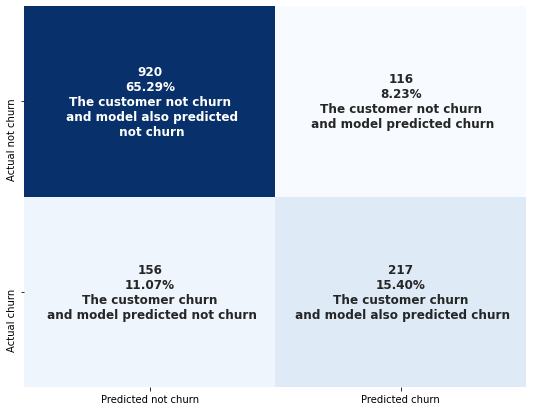

In [62]:
predictions_train = logreg.predict(X_train.values)
predictions = logreg.predict(X_test.values)

print('\033[1mTraining Accuracy Percentage\033[0m: %.2f' % (accuracy_score(y_train, predictions_train)*100))
fpr, tpr, thresholds = metrics.roc_curve(y_train, predictions_train)
print('\033[1mTraining Auc score\033[0m: %.2f' % (metrics.auc(fpr, tpr)))

print('\033[1mTesting Accuracy Percentage\033[0m: %.2f' % (accuracy_score(y_test, predictions)*100))
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions)
print('\033[1mTesting Auc score\033[0m: %.2f' % (metrics.auc(fpr, tpr)))

#print ("\naccuracy_score :",accuracy_score(y_val, predictions))

print ("\nclassification report testing:\n",(classification_report(y_test, predictions)))
from sklearn.metrics import confusion_matrix
print('\033[1mConfusion_Matrix\033[0m')
confusion_matrix = confusion_matrix(y_test, predictions)
#group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                confusion_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     confusion_matrix.flatten()/np.sum(confusion_matrix)]

group_description = ['The customer not churn\n and model also predicted\n not churn',
                     'The customer not churn\n and model predicted churn',
                    'The customer churn\n and model predicted not churn',
                     'The customer churn\n and model also predicted churn']
labels = [f"{v3}\n{v1}\n{v2}" for v1, v2, v3 in
          zip(group_percentages,group_description,group_counts)]
labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues',
            annot_kws={'fontsize':'large','fontweight':'bold'}
           ,cbar=False,xticklabels=['Predicted not churn','Predicted churn']
            ,yticklabels=['Actual not churn','Actual churn'])

plt.show()

## GradientBoostingClassifier

In [63]:
with mlflow.start_run(run_name="GradientBoostingClassifier"):
    clf = GradientBoostingClassifier()
    clf.fit(X_train, y_train)
    
    
    y_pred_tr = clf.predict(X_train)
    roc_auc_train = roc_auc_score(y_train, y_pred_tr)
    train_accuracy = accuracy_score(y_train, y_pred_tr)
    
    
    y_pred = clf.predict(X_test)
    roc_auc_test = roc_auc_score(y_test, y_pred)
    test_accuracy = accuracy_score(y_test, y_pred)
    
    mlflow.log_metric("train_auc", roc_auc_train)
    mlflow.log_metric("test_auc", roc_auc_test)
    
    mlflow.log_metric("train_accuracy", train_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)
    
    mlflow.sklearn.log_model(clf, f"GradientBoostingClassifier")

Training Accuracy Percentage: 82.32
Training Auc score: 0.74
Testing Accuracy Percentage: 81.19
Testing Auc score: 0.72

classification report testing:
               precision    recall  f1-score   support

           0       0.84      0.91      0.88      1036
           1       0.69      0.53      0.60       373

    accuracy                           0.81      1409
   macro avg       0.77      0.72      0.74      1409
weighted avg       0.80      0.81      0.80      1409

Confusion_Matrix


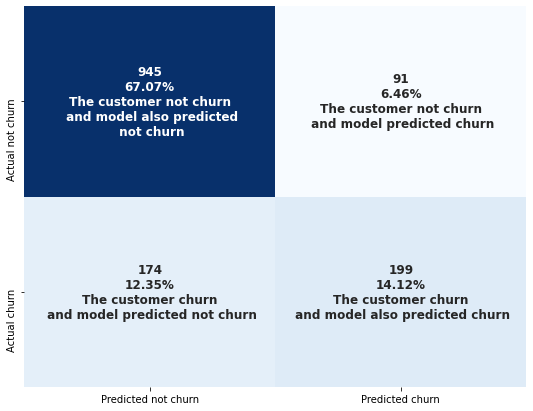

In [64]:
predictions_train = clf.predict(X_train.values)
predictions = clf.predict(X_test.values)

print('\033[1mTraining Accuracy Percentage\033[0m: %.2f' % (accuracy_score(y_train, predictions_train)*100))
fpr, tpr, thresholds = metrics.roc_curve(y_train, predictions_train)
print('\033[1mTraining Auc score\033[0m: %.2f' % (metrics.auc(fpr, tpr)))

print('\033[1mTesting Accuracy Percentage\033[0m: %.2f' % (accuracy_score(y_test, predictions)*100))
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions)
print('\033[1mTesting Auc score\033[0m: %.2f' % (metrics.auc(fpr, tpr)))

#print ("\naccuracy_score :",accuracy_score(y_val, predictions))

print ("\nclassification report testing:\n",(classification_report(y_test, predictions)))
from sklearn.metrics import confusion_matrix
print('\033[1mConfusion_Matrix\033[0m')
confusion_matrix = confusion_matrix(y_test, predictions)
#group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                confusion_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     confusion_matrix.flatten()/np.sum(confusion_matrix)]

group_description = ['The customer not churn\n and model also predicted\n not churn',
                     'The customer not churn\n and model predicted churn',
                    'The customer churn\n and model predicted not churn',
                     'The customer churn\n and model also predicted churn']
labels = [f"{v3}\n{v1}\n{v2}" for v1, v2, v3 in
          zip(group_percentages,group_description,group_counts)]
labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues',
            annot_kws={'fontsize':'large','fontweight':'bold'}
           ,cbar=False,xticklabels=['Predicted not churn','Predicted churn']
            ,yticklabels=['Actual not churn','Actual churn'])

plt.show()

## RandomForestClassifier

In [65]:
with mlflow.start_run(run_name="RandomForestClassifier"):
    clf = RandomForestClassifier(random_state = 42)
    clf.fit(X_train, y_train)
    

    
    y_pred_tr = clf.predict(X_train)
    roc_auc_train = roc_auc_score(y_train, y_pred_tr)
    train_accuracy = accuracy_score(y_train, y_pred_tr)
    
    
    y_pred = clf.predict(X_test)
    roc_auc_test = roc_auc_score(y_test, y_pred)
    test_accuracy = accuracy_score(y_test, y_pred)
    
    mlflow.log_metric("train_auc", roc_auc_train)
    mlflow.log_metric("test_auc", roc_auc_test)
    
    mlflow.log_metric("train_accuracy", train_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)
    
    mlflow.sklearn.log_model(clf, f"RandomForestClassifier")

Training Accuracy Percentage: 99.65
Training Auc score: 1.00
Testing Accuracy Percentage: 79.42
Testing Auc score: 0.70

classification report testing:
               precision    recall  f1-score   support

           0       0.83      0.90      0.87      1036
           1       0.64      0.51      0.57       373

    accuracy                           0.79      1409
   macro avg       0.74      0.70      0.72      1409
weighted avg       0.78      0.79      0.79      1409

Confusion_Matrix


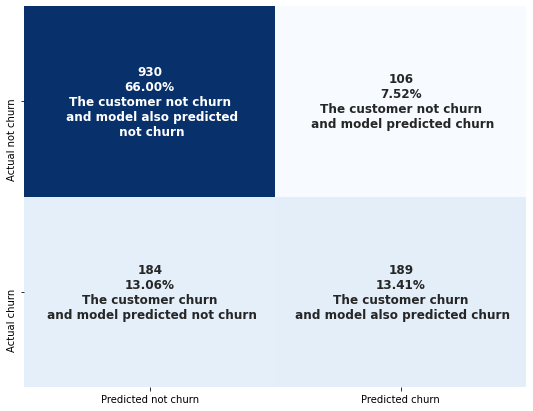

In [66]:
predictions_train = clf.predict(X_train.values)
predictions = clf.predict(X_test.values)

print('\033[1mTraining Accuracy Percentage\033[0m: %.2f' % (accuracy_score(y_train, predictions_train)*100))
fpr, tpr, thresholds = metrics.roc_curve(y_train, predictions_train)
print('\033[1mTraining Auc score\033[0m: %.2f' % (metrics.auc(fpr, tpr)))

print('\033[1mTesting Accuracy Percentage\033[0m: %.2f' % (accuracy_score(y_test, predictions)*100))
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions)
print('\033[1mTesting Auc score\033[0m: %.2f' % (metrics.auc(fpr, tpr)))

#print ("\naccuracy_score :",accuracy_score(y_val, predictions))

print ("\nclassification report testing:\n",(classification_report(y_test, predictions)))
from sklearn.metrics import confusion_matrix
print('\033[1mConfusion_Matrix\033[0m')
confusion_matrix = confusion_matrix(y_test, predictions)
#group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                confusion_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     confusion_matrix.flatten()/np.sum(confusion_matrix)]

group_description = ['The customer not churn\n and model also predicted\n not churn',
                     'The customer not churn\n and model predicted churn',
                    'The customer churn\n and model predicted not churn',
                     'The customer churn\n and model also predicted churn']
labels = [f"{v3}\n{v1}\n{v2}" for v1, v2, v3 in
          zip(group_percentages,group_description,group_counts)]
labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues',
            annot_kws={'fontsize':'large','fontweight':'bold'}
           ,cbar=False,xticklabels=['Predicted not churn','Predicted churn']
            ,yticklabels=['Actual not churn','Actual churn'])

plt.show()

## AdaBoostClassifier

In [67]:
with mlflow.start_run(run_name="AdaBoostClassifier"):
    clf = AdaBoostClassifier(random_state = 42)
    clf.fit(X_train, y_train)
    

    
    y_pred_tr = clf.predict(X_train)
    roc_auc_train = roc_auc_score(y_train, y_pred_tr)
    train_accuracy = accuracy_score(y_train, y_pred_tr)
    
    
    y_pred = clf.predict(X_test)
    roc_auc_test = roc_auc_score(y_test, y_pred)
    test_accuracy = accuracy_score(y_test, y_pred)
    
    mlflow.log_metric("train_auc", roc_auc_train)
    mlflow.log_metric("test_auc", roc_auc_test)
    
    mlflow.log_metric("train_accuracy", train_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)
    
    mlflow.sklearn.log_model(clf, f"AdaBoostClassifier")

Training Accuracy Percentage: 80.42
Training Auc score: 0.72
Testing Accuracy Percentage: 80.84
Testing Auc score: 0.73

classification report testing:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1036
           1       0.66      0.57      0.61       373

    accuracy                           0.81      1409
   macro avg       0.76      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409

Confusion_Matrix


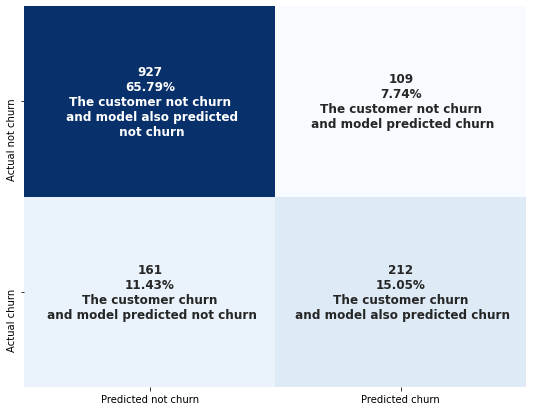

In [68]:
predictions_train = clf.predict(X_train.values)
predictions = clf.predict(X_test.values)

print('\033[1mTraining Accuracy Percentage\033[0m: %.2f' % (accuracy_score(y_train, predictions_train)*100))
fpr, tpr, thresholds = metrics.roc_curve(y_train, predictions_train)
print('\033[1mTraining Auc score\033[0m: %.2f' % (metrics.auc(fpr, tpr)))

print('\033[1mTesting Accuracy Percentage\033[0m: %.2f' % (accuracy_score(y_test, predictions)*100))
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions)
print('\033[1mTesting Auc score\033[0m: %.2f' % (metrics.auc(fpr, tpr)))

#print ("\naccuracy_score :",accuracy_score(y_val, predictions))

print ("\nclassification report testing:\n",(classification_report(y_test, predictions)))
from sklearn.metrics import confusion_matrix
print('\033[1mConfusion_Matrix\033[0m')
confusion_matrix = confusion_matrix(y_test, predictions)
#group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                confusion_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     confusion_matrix.flatten()/np.sum(confusion_matrix)]

group_description = ['The customer not churn\n and model also predicted\n not churn',
                     'The customer not churn\n and model predicted churn',
                    'The customer churn\n and model predicted not churn',
                     'The customer churn\n and model also predicted churn']
labels = [f"{v3}\n{v1}\n{v2}" for v1, v2, v3 in
          zip(group_percentages,group_description,group_counts)]
labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues',
            annot_kws={'fontsize':'large','fontweight':'bold'}
           ,cbar=False,xticklabels=['Predicted not churn','Predicted churn']
            ,yticklabels=['Actual not churn','Actual churn'])

plt.show()

## CatBoostClassifier

In [69]:
with mlflow.start_run(run_name="CatBoostClassifier"):
    clf = CatBoostClassifier(random_seed = 42)
    clf.fit(X_train, y_train,verbose=True)
    

    
    y_pred_tr = clf.predict(X_train)
    roc_auc_train = roc_auc_score(y_train, y_pred_tr)
    train_accuracy = accuracy_score(y_train, y_pred_tr)
    
    
    y_pred = clf.predict(X_test)
    roc_auc_test = roc_auc_score(y_test, y_pred)
    test_accuracy = accuracy_score(y_test, y_pred)
    
    mlflow.log_metric("train_auc", roc_auc_train)
    mlflow.log_metric("test_auc", roc_auc_test)
    
    mlflow.log_metric("train_accuracy", train_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)
    
    mlflow.sklearn.log_model(clf, f"CatBoostClassifier")

Learning rate set to 0.021554
0:	learn: 0.6786953	total: 2.02ms	remaining: 2.02s
1:	learn: 0.6652767	total: 4.07ms	remaining: 2.03s
2:	learn: 0.6523502	total: 6.1ms	remaining: 2.03s
3:	learn: 0.6401423	total: 8.16ms	remaining: 2.03s
4:	learn: 0.6283117	total: 10.2ms	remaining: 2.03s
5:	learn: 0.6168693	total: 12.3ms	remaining: 2.03s
6:	learn: 0.6063799	total: 14.3ms	remaining: 2.03s
7:	learn: 0.5967539	total: 16.3ms	remaining: 2.02s
8:	learn: 0.5876593	total: 18.4ms	remaining: 2.02s
9:	learn: 0.5788196	total: 20.4ms	remaining: 2.02s
10:	learn: 0.5709021	total: 22.5ms	remaining: 2.02s
11:	learn: 0.5630057	total: 24.5ms	remaining: 2.02s
12:	learn: 0.5555674	total: 26.6ms	remaining: 2.02s
13:	learn: 0.5484744	total: 28.7ms	remaining: 2.02s
14:	learn: 0.5418060	total: 30.8ms	remaining: 2.02s
15:	learn: 0.5354481	total: 32.9ms	remaining: 2.02s
16:	learn: 0.5299779	total: 35ms	remaining: 2.02s
17:	learn: 0.5245122	total: 37.1ms	remaining: 2.02s
18:	learn: 0.5189681	total: 39.2ms	remaining: 2

Training Accuracy Percentage: 86.37
Training Auc score: 0.79
Testing Accuracy Percentage: 80.70
Testing Auc score: 0.72

classification report testing:
               precision    recall  f1-score   support

           0       0.84      0.91      0.87      1036
           1       0.67      0.53      0.59       373

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409

Confusion_Matrix


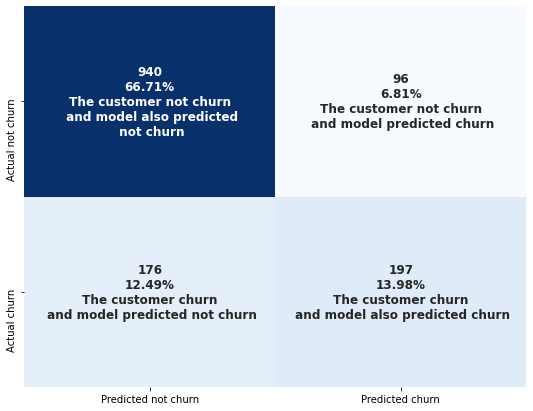

In [70]:
predictions_train = clf.predict(X_train.values)
predictions = clf.predict(X_test.values)

print('\033[1mTraining Accuracy Percentage\033[0m: %.2f' % (accuracy_score(y_train, predictions_train)*100))
fpr, tpr, thresholds = metrics.roc_curve(y_train, predictions_train)
print('\033[1mTraining Auc score\033[0m: %.2f' % (metrics.auc(fpr, tpr)))

print('\033[1mTesting Accuracy Percentage\033[0m: %.2f' % (accuracy_score(y_test, predictions)*100))
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions)
print('\033[1mTesting Auc score\033[0m: %.2f' % (metrics.auc(fpr, tpr)))

#print ("\naccuracy_score :",accuracy_score(y_val, predictions))

print ("\nclassification report testing:\n",(classification_report(y_test, predictions)))
from sklearn.metrics import confusion_matrix
print('\033[1mConfusion_Matrix\033[0m')
confusion_matrix = confusion_matrix(y_test, predictions)
#group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                confusion_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     confusion_matrix.flatten()/np.sum(confusion_matrix)]

group_description = ['The customer not churn\n and model also predicted\n not churn',
                     'The customer not churn\n and model predicted churn',
                    'The customer churn\n and model predicted not churn',
                     'The customer churn\n and model also predicted churn']
labels = [f"{v3}\n{v1}\n{v2}" for v1, v2, v3 in
          zip(group_percentages,group_description,group_counts)]
labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues',
            annot_kws={'fontsize':'large','fontweight':'bold'}
           ,cbar=False,xticklabels=['Predicted not churn','Predicted churn']
            ,yticklabels=['Actual not churn','Actual churn'])

plt.show()

In [71]:
# Select the run of the experiment
df_runs = mlflow.search_runs(experiment_ids=exp_id)
print("Number of runs done : ", len(df_runs))
df_runs

Number of runs done :  5


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_accuracy,metrics.train_accuracy,metrics.test_auc,metrics.train_auc,tags.mlflow.source.type,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.log-model.history,tags.mlflow.runName
0,c64df7899e7d41568f74097cffab07e9,69,FINISHED,s3://models/69/c64df7899e7d41568f74097cffab07e...,2021-07-23 01:18:02.883000+00:00,2021-07-23 01:18:05.708000+00:00,0.806955,0.863685,0.717743,0.792823,LOCAL,/opt/miniconda/lib/python3.7/site-packages/ipy...,root,"[{""run_id"": ""c64df7899e7d41568f74097cffab07e9""...",CatBoostClassifier
1,fe5119668bfe477385319891ee193a4f,69,FINISHED,s3://models/69/fe5119668bfe477385319891ee193a4...,2021-07-23 01:18:02.285000+00:00,2021-07-23 01:18:02.711000+00:00,0.808375,0.804224,0.731576,0.717561,LOCAL,/opt/miniconda/lib/python3.7/site-packages/ipy...,root,"[{""run_id"": ""fe5119668bfe477385319891ee193a4f""...",AdaBoostClassifier
2,14316f7a42c84eb987c0f7d71aff55c0,69,FINISHED,s3://models/69/14316f7a42c84eb987c0f7d71aff55c...,2021-07-23 01:18:01.128000+00:00,2021-07-23 01:18:02.052000+00:00,0.794180,0.996450,0.702193,0.995876,LOCAL,/opt/miniconda/lib/python3.7/site-packages/ipy...,root,"[{""run_id"": ""14316f7a42c84eb987c0f7d71aff55c0""...",RandomForestClassifier
3,fcc599e072524b5da2f524ff0172604a,69,FINISHED,s3://models/69/fcc599e072524b5da2f524ff0172604...,2021-07-23 01:18:00.152000+00:00,2021-07-23 01:18:00.986000+00:00,0.811923,0.823216,0.722837,0.736892,LOCAL,/opt/miniconda/lib/python3.7/site-packages/ipy...,root,"[{""run_id"": ""fcc599e072524b5da2f524ff0172604a""...",GradientBoostingClassifier
4,9058018e47b34153a7d27cafde3f8d7b,69,FINISHED,s3://models/69/9058018e47b34153a7d27cafde3f8d7...,2021-07-23 01:17:59.576000+00:00,2021-07-23 01:17:59.928000+00:00,0.806955,0.789670,0.734900,0.711067,LOCAL,/opt/miniconda/lib/python3.7/site-packages/ipy...,root,"[{""run_id"": ""9058018e47b34153a7d27cafde3f8d7b""...",logistic_regression


## Evaluating  Models

In [72]:
top_runs = df_runs.sort_values(['metrics.test_auc'],ascending=False)
top_runs.head()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_accuracy,metrics.train_accuracy,metrics.test_auc,metrics.train_auc,tags.mlflow.source.type,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.log-model.history,tags.mlflow.runName
4,9058018e47b34153a7d27cafde3f8d7b,69,FINISHED,s3://models/69/9058018e47b34153a7d27cafde3f8d7...,2021-07-23 01:17:59.576000+00:00,2021-07-23 01:17:59.928000+00:00,0.806955,0.789670,0.734900,0.711067,LOCAL,/opt/miniconda/lib/python3.7/site-packages/ipy...,root,"[{""run_id"": ""9058018e47b34153a7d27cafde3f8d7b""...",logistic_regression
1,fe5119668bfe477385319891ee193a4f,69,FINISHED,s3://models/69/fe5119668bfe477385319891ee193a4...,2021-07-23 01:18:02.285000+00:00,2021-07-23 01:18:02.711000+00:00,0.808375,0.804224,0.731576,0.717561,LOCAL,/opt/miniconda/lib/python3.7/site-packages/ipy...,root,"[{""run_id"": ""fe5119668bfe477385319891ee193a4f""...",AdaBoostClassifier
3,fcc599e072524b5da2f524ff0172604a,69,FINISHED,s3://models/69/fcc599e072524b5da2f524ff0172604...,2021-07-23 01:18:00.152000+00:00,2021-07-23 01:18:00.986000+00:00,0.811923,0.823216,0.722837,0.736892,LOCAL,/opt/miniconda/lib/python3.7/site-packages/ipy...,root,"[{""run_id"": ""fcc599e072524b5da2f524ff0172604a""...",GradientBoostingClassifier
0,c64df7899e7d41568f74097cffab07e9,69,FINISHED,s3://models/69/c64df7899e7d41568f74097cffab07e...,2021-07-23 01:18:02.883000+00:00,2021-07-23 01:18:05.708000+00:00,0.806955,0.863685,0.717743,0.792823,LOCAL,/opt/miniconda/lib/python3.7/site-packages/ipy...,root,"[{""run_id"": ""c64df7899e7d41568f74097cffab07e9""...",CatBoostClassifier
2,14316f7a42c84eb987c0f7d71aff55c0,69,FINISHED,s3://models/69/14316f7a42c84eb987c0f7d71aff55c...,2021-07-23 01:18:01.128000+00:00,2021-07-23 01:18:02.052000+00:00,0.794180,0.996450,0.702193,0.995876,LOCAL,/opt/miniconda/lib/python3.7/site-packages/ipy...,root,"[{""run_id"": ""14316f7a42c84eb987c0f7d71aff55c0""...",RandomForestClassifier


## Selecting best model

In [73]:
artifacts = top_runs.iloc[0]["artifact_uri"]
run_id = top_runs.iloc[0]["run_id"]
model_name = top_runs.iloc[0]["tags.mlflow.runName"] 


print('Best model_artifacts :',artifacts)
print("=" * 100)
print('Best model run_id :',run_id)
print("=" * 100)
print('Best model :',model_name)
print("=" * 100)
print("Best model experiment id :",exp_id)

Best model_artifacts : s3://models/69/9058018e47b34153a7d27cafde3f8d7b/artifacts
Best model run_id : 9058018e47b34153a7d27cafde3f8d7b
Best model : logistic_regression
Best model experiment id : 69


## Registering best model

In [74]:
result = mlflow.register_model(
    "runs:/" + run_id,
    MODEL_NAME+'_'+model_name
)

Registered model 'telecom_customer_churn_logistic_regression' already exists. Creating a new version of this model...
2021/07/23 01:18:31 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: telecom_customer_churn_logistic_regression, version 3
Created version '3' of model 'telecom_customer_churn_logistic_regression'.


In [75]:
print('Registered model information :')
print('=='*50)
print(pd.DataFrame(result, columns =['Attribute','Value']))

Registered model information :
                 Attribute                                              Value
0       creation_timestamp                                      1627003111932
1            current_stage                                               None
2              description                                                   
3   last_updated_timestamp                                      1627003111932
4                     name         telecom_customer_churn_logistic_regression
5                   run_id                   9058018e47b34153a7d27cafde3f8d7b
6                 run_link                                                   
7                   source  s3://models/69/9058018e47b34153a7d27cafde3f8d7...
8                   status                                              READY
9           status_message                                                   
10                    tags                                                 {}
11                 user_id       

In [34]:
print('Experiment information :')
print('=='*50)
print(pd.DataFrame(exp_details, columns =['Attribute','Value']))

Experiment information :
           Attribute                   Value
0  artifact_location          s3://models/67
1      experiment_id                      67
2    lifecycle_stage                  active
3               name  telecom_customer_churn
4               tags                      {}


## Transit model to Production

In [78]:
production_model = client.transition_model_version_stage(
     name='telecom_customer_churn_logistic_regression',
     version=3,
     stage="Production")

In [79]:
print('Production model information :')
print('=='*50)
print(pd.DataFrame(result, columns =['Attribute','Value']))

Production model information :
                 Attribute                                              Value
0       creation_timestamp                                      1627003111932
1            current_stage                                               None
2              description                                                   
3   last_updated_timestamp                                      1627003111932
4                     name         telecom_customer_churn_logistic_regression
5                   run_id                   9058018e47b34153a7d27cafde3f8d7b
6                 run_link                                                   
7                   source  s3://models/69/9058018e47b34153a7d27cafde3f8d7...
8                   status                                              READY
9           status_message                                                   
10                    tags                                                 {}
11                 user_id       

## storing best model meta

In [36]:

time = pd.to_datetime(datetime.now())

In [37]:
dictionary = [{"model":model_name,
             "location":artifacts+'/'+model_name,
             "run_id":run_id,
            'experiment_id':exp_id,
              'prod_time':time,
              'top_features':top,
              }]

In [38]:
dataset = pd.DataFrame(dictionary)
dataset

,model,location,run_id,experiment_id,prod_time,top_features
0,GradientBoostingClassifier,s3://models/67/138ffc8642694325888d7ff89743bfc...,138ffc8642694325888d7ff89743bfc9,67,2021-07-16 03:15:05.241946,"[tenure, InternetService, OnlineSecurity, Onli..."


In [39]:
POSTGRES_PASSWORD = passwrd_parser(POSTGRES_PASSWORD)
write_to_feature_store(POSTGRES_USERNAME,POSTGRES_PASSWORD,POSTGRES_ADDRESS,
                       POSTGRES_PORT,POSTGRES_DBNAME,PROJECT_SCHEMA,dataset,TABLE_MODEL)

In [40]:
read_from_feature_store(POSTGRES_USERNAME,POSTGRES_PASSWORD,POSTGRES_ADDRESS,POSTGRES_PORT,POSTGRES_DBNAME,PROJECT_SCHEMA,TABLE_MODEL)

,model,location,run_id,experiment_id,prod_time,top_features
0,GradientBoostingClassifier,s3://models/67/138ffc8642694325888d7ff89743bfc...,138ffc8642694325888d7ff89743bfc9,67,2021-07-16 03:15:05.241946,"{tenure,InternetService,OnlineSecurity,OnlineB..."
